Demonstration notebook showing an example alignment of the SAXS pin diode. While there is no beam, a simulated noisy detector will be used with the pin diode motors to align a peak.

In [3]:
#Start Bluesky and import devices, plans

import pathlib, sys
sys.path.append(str("/home/beams/S1IDTEST/bluesky/"))

from instrument.collection import *

I Wed-16:36:27 - /home/beams/S1IDTEST/bluesky/instrument/collection.py
I Wed-16:36:27 - CONDA_PREFIX = /home/beams/S1IDUSER/.conda/envs/bluesky_2024_1


Exception reporting mode: Minimal


I Wed-16:36:27 - xmode exception level: 'Minimal'
I Wed-16:36:27 - #### Bluesky Framework ####
I Wed-16:36:27 - #### Devices ####
I Wed-16:36:27 - /home/beams/S1IDTEST/bluesky/instrument/devices/ioc1ide1_motors.py
I Wed-16:36:28 - /home/beams/S1IDTEST/bluesky/instrument/devices/generic_motors.py
I Wed-16:36:28 - /home/beams/S1IDTEST/bluesky/instrument/devices/ioc1idc_motors.py
I Wed-16:36:29 - /home/beams/S1IDTEST/bluesky/instrument/devices/ioc1ide_scalers.py
I Wed-16:36:34 - /home/beams/S1IDTEST/bluesky/instrument/devices/s1id_shutters.py


/home/beams/S1IDUSER/.conda/envs/bluesky_2024_1/lib/python3.11/site-packages/apstools/devices/aps_data_management.py


I Wed-16:36:34 - /home/beams/S1IDTEST/bluesky/instrument/devices/s1id_slits.py
I Wed-16:36:34 - #### Callbacks ####
I Wed-16:36:34 - /home/beams/S1IDTEST/bluesky/instrument/callbacks/spec_data_file_writer.py
I Wed-16:36:34 - #### Plans ####
I Wed-16:36:34 - /home/beams/S1IDTEST/bluesky/instrument/plans/bdp202403.py
I Wed-16:36:34 - /home/beams/S1IDTEST/bluesky/instrument/plans/ad_setup_plans.py
I Wed-16:36:34 - /home/beams/S1IDTEST/bluesky/instrument/plans/software_triggering.py
I Wed-16:36:34 - /home/beams/S1IDTEST/bluesky/instrument/plans/saxs_startup.py


ImportError: cannot import name 'lineup2' from 'apstools.plans' (/home/beams/S1IDUSER/.conda/envs/bluesky_2024_1/lib/python3.11/site-packages/apstools/plans/__init__.py)

In [4]:
sys.path.append("/home/beams/S1IDTEST/bluesky/instrument/devices")

for p in sys.path: print(p)

/home/beams0/S1IDTEST/bluesky/user
/home/beams/S1IDUSER/.conda/envs/bluesky_2024_1/lib/python311.zip
/home/beams/S1IDUSER/.conda/envs/bluesky_2024_1/lib/python3.11
/home/beams/S1IDUSER/.conda/envs/bluesky_2024_1/lib/python3.11/lib-dynload

/home/beams/S1IDUSER/.conda/envs/bluesky_2024_1/lib/python3.11/site-packages
/home/beams/S1IDTEST/bluesky/
/home/beams/S1IDTEST/bluesky
home/beams/S1IDTEST/bluesky/instrument/devices
home/beams/S1IDTEST/bluesky/instrument/devices
/home/beams/S1IDTEST/bluesky/
/home/beams/S1IDTEST/bluesky/instrument/devices
/home/beams/S1IDTEST/bluesky/instrument/devices
/home/beams/S1IDTEST/bluesky/instrument/devices


In [3]:
from apstools.plans import lineup2

#RE(lineup2(noisy, motor, -10, 10, 41, nscans = 3))

#print(f"{motor.position=}")

In [ ]:
import databroker
cat = databroker.catalog["1id_hexm"]

ds = cat[uid[0]].primary.read()

print(ds[m1.name].data)

In [66]:
def choose_system(SMS):
    """ 
    For choosing which tomo and sms motors.
    """
    #FIXME: adjust to realistic in/out positions
    tomo_motor = tomo_e.x
    tomox_in = 0
    tomox_out = 10

    if SMS == "aero":
        sample_motor = sms_aero.x2
        samplex_out = 10
    elif SMS == "mts":
        sample_motor = mts.x2 
        samplex_out = 15
    elif SMS == "lab":
        sample_motor = sms_lab.x2
        samplex_out = 11
        tomo_motor = tomo_c.x
        tomox_in = 1
        tomox_out = 13        
    else:
        raise NameError("SMS is not defined.") 
    
    return tomox_out, tomo_motor,tomox_in, tomox_out, sample_motor, samplex_out



SyntaxError: invalid syntax (857534517.py, line 25)

In [56]:
[tomox_out, tomo_motor,tomox_in, tomox_out, sample_motor, samplex_out] = choose_system("lab")
print(tomo_motor)

EpicsMotor(prefix='1idcm79', name='tomo_c_x', parent='tomo_c', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu'])


In [64]:

def diode_align(
    sms = "aero",
    startpos = 0,       #initial position of lineup scan (absolute)
    startr = -10,       #lineup scan start (relative)
    endr = 10,          #lineup scan end (relative)
    points = 51,            #number of steps in scan 
    peak_sens = 2.5,    #threshold for detected peak amplitde
    width_sens = 0.8,   #threshold for detected peak width
    nscans = 3               #number of scans
):
    
    det = noisy
    motor_x = motor
    #startr= -9
    #endr = 9
    
    [tomox_out, tomo_motor,tomox_in, tomox_out, sample_motor, samplex_out] = choose_system(sms)
    print(f"{tomox_in=}")
    
    yield from bps.mv(motor, startpos)
    
    print(f"{motor.position=}")
    
    yield from lineup2(
        detectors = det, mover = motor_x,
        rel_start = startr, rel_end = endr, 
        points = points, peak_factor = peak_sens, 
        width_factor = width_sens, nscans = nscans,
        md={"title":"SAXS diode lineup scan"}
    )
    
    print(f"Diode position after {nscans} scans = {motor_x.position}")


tomox_in=0
motor.position=0.0


Transient Scan ID: 123     Time: 2024-02-15 14:16:15
Persistent Unique Scan ID: '997359fb-23e9-42db-a787-4593c3997f33'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |      noisy |
+-----------+------------+------------+------------+
|         1 | 14:16:15.6 |    -10.000 |     -0.004 |
|         2 | 14:16:15.6 |     -9.600 |      0.008 |
|         3 | 14:16:15.7 |     -9.200 |     -0.000 |
|         4 | 14:16:15.7 |     -8.800 |     -0.006 |
|         5 | 14:16:16.0 |     -8.400 |      0.005 |
|         6 | 14:16:16.1 |     -8.000 |     -0.001 |
|         7 | 14:16:16.1 |     -7.600 |      0.003 |
|         8 | 14:16:16.2 |     -7.200 |      0.006 |
|         9 | 14:16:16.2 |     -6.800 |      0.007 |
|        10 | 14:16:16.3 |     -6.400 |     -0.001 |
|        11 | 14:16:16.4 |     -6.000 |     -0.006 |
|        12 | 14:16:16.4 |     -5.600 |     -0.002 |
|        13 | 14:16:16.5 |     -

('997359fb-23e9-42db-a787-4593c3997f33',
 'b8ee8122-0a33-40ab-be27-22b58c3aa25d',
 '4a68d49d-7440-4693-9cbd-1c33a634c0b5')

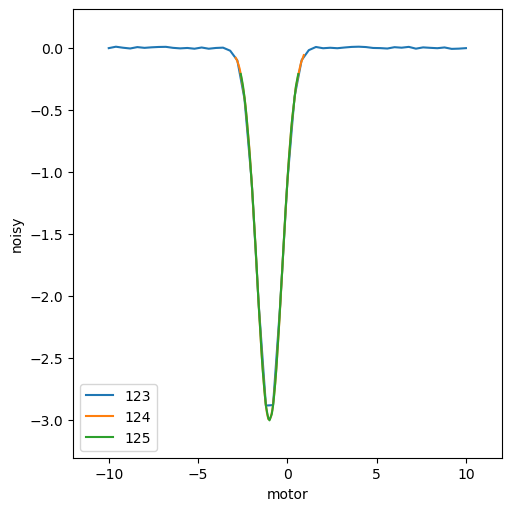

In [65]:
RE(diode_align(sms = "aero"))



In [61]:
print(tomox_in)

1


In [50]:
print(tomox_out)

NameError: name 'tomox_out' is not defined